In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

LOADING THE DATASET

In [ ]:
from datasets import load_dataset
from transformers import BertTokenizer
from torch.utils.data import DataLoader
import torch

# Load IMDb dataset
dataset = load_dataset("imdb")

# Load pretrained tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
def tokenize_function(example):
    return tokenizer(
        example['text'],
        padding="max_length",
        truncation=True,
        max_length=256
    )

# Apply tokenization
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Create DataLoaders
train_loader = DataLoader(tokenized_datasets['train'], batch_size=32, shuffle=True)
test_loader = DataLoader(tokenized_datasets['test'], batch_size=32)

# Inspect one batch
for batch in train_loader:
    print(batch['input_ids'].shape)     # [32, 256]
    print(batch['attention_mask'].shape)
    print(batch['label'])
    break


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

torch.Size([32, 256])
torch.Size([32, 256])
tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 0])


POSITIONAL ENCODER

In [ ]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * -(math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.pe = pe.unsqueeze(0)  # [1, max_len, embed_dim]

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)


ENCODER

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_mask=None):
        attn_output, _ = self.attn(x, x, x, key_padding_mask=src_mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


TRANSFORMER

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, num_classes, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.pos_encoding = PositionalEncoding(embed_dim)
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, ff_dim)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = self.pos_encoding(x)
        # Convert attention_mask (1: real, 0: pad) to key_padding_mask (True: pad, False: real)
        key_padding_mask = ~attention_mask.bool()
        for layer in self.layers:
            x = layer(x, src_mask=key_padding_mask)
        x = x.mean(dim=1)  # Average pooling
        return self.classifier(x)


TRAINING THE MODEL

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = TransformerClassifier(
    vocab_size=tokenizer.vocab_size,
    embed_dim=128,
    num_heads=4,
    ff_dim=256,
    num_layers=2,
    num_classes=2,
    pad_idx=tokenizer.pad_token_id
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# For tracking
train_losses = []
val_losses = []

# Split validation set manually from training set (optional)
from torch.utils.data import random_split

train_size = int(0.9 * len(tokenized_datasets['train']))
val_size = len(tokenized_datasets['train']) - train_size
train_dataset, val_dataset = random_split(tokenized_datasets['train'], [train_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=32)

for epoch in range(10):
    model.train()
    total_train_loss = 0
    for batch in DataLoader(train_dataset, batch_size=32, shuffle=True):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation loss
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    train_losses.append(total_train_loss)
    val_losses.append(total_val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {total_train_loss:.2f}, Val Loss: {total_val_loss:.2f}")


Epoch 1, Train Loss: 437.70, Val Loss: 43.21
Epoch 2, Train Loss: 357.35, Val Loss: 37.90
Epoch 3, Train Loss: 300.27, Val Loss: 33.69
Epoch 4, Train Loss: 269.36, Val Loss: 31.60
Epoch 5, Train Loss: 247.31, Val Loss: 31.25
Epoch 6, Train Loss: 228.83, Val Loss: 31.73
Epoch 7, Train Loss: 213.32, Val Loss: 31.53
Epoch 8, Train Loss: 201.13, Val Loss: 30.47
Epoch 9, Train Loss: 184.14, Val Loss: 30.89
Epoch 10, Train Loss: 171.03, Val Loss: 33.07


VISUALIZING TRAINING AND VALIDATION LOSS

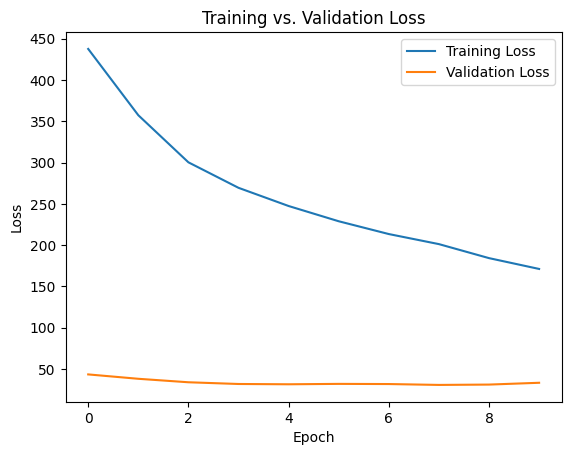

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()


TEST ACCURACY

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 82.65%
